In [1]:
import os
os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import multi_agent_reinforcement_learning
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import lognorm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
import matplotlib
import scipy.stats as stats

In [4]:
city_idx = 3 #0, 1, 2, 3
cities = ['san_francisco', 'nyc_brooklyn', 'shenzhen_downtown_west', 'washington_dc']
city_names = ["San Francisco", "Brooklyn, New York", "Shenzhen Downtown West", "Washington D.C."]
city = cities[city_idx]
city_name = city_names[city_idx]
with open(f"./data/scenario_{city}.json") as f:
    data = json.loads(f.read())

In [5]:
df = pd.DataFrame(data["demand"])

In [6]:
json_start = 19*60
json_tstep = 3
df["converted_time_stamp"] = (df["time_stamp"]- json_start) // json_tstep

In [7]:
# i = 5
# j = 9
# for step in range(20):
#     loc_time_mask = (
#         (df["origin"] == i)
#         & (df["destination"] == j)
#         & (
#             (
#                 df["time_stamp"]
#                 - 19 * 60
#             )
#             // 3
#             == step
#         )
#     )
#     print(df.loc[loc_time_mask, "travel_time"].mean(), step)


In [8]:
reb_df = pd.DataFrame(data["rebTime"])
reb_df = reb_df[reb_df["time_stamp"]==19]

In [9]:
df_new = df.merge(reb_df, on=["origin", "destination"])

In [10]:
#smf.ols(formula="price ~ reb_time", data=df_new).fit()

In [11]:
org, dest = 5, 9
test = df[(df["origin"] == org) & (df["destination"] == dest)] # 3.466

In [12]:
((test.travel_time * test.demand * 2/3) / (test.demand * 2)).round().unique()

array([5.])

# Simple summary stats

In [13]:
df_org_dest = df.groupby(["origin", "destination"]).agg({"price": ["count", "mean"], "demand": "mean", "travel_time":"mean"}).reset_index()

In [14]:
df_org_dest.head()

origin destination price               demand travel_time
                     count       mean      mean        mean
0      0           1   120  13.400000  0.066667   14.000000
1      0           2   180  15.266667  0.077778   20.666667
2      0           3   180  12.166667  0.138889   14.333333
3      0           4   180   9.333333  0.688889    9.666667
4      0           5   180  12.433333  0.838889   14.666667

In [15]:
df_org_dest.columns = df_org_dest.columns.droplevel(0)
df_org_dest.columns = ["Origin", "Destination", "count", "mean_price", "mean_demand", "mean_travel_time"]

In [16]:
df.describe()

,time_stamp,origin,destination,demand,travel_time,price,converted_time_stamp
count,24780.000000,24780.000000,24780.000000,24780.000000,24780.000000,24780.000000,24780.000000
mean,1227.320823,5.992736,7.576271,0.121186,13.871671,11.722518,28.773608
std,51.719791,4.017892,4.392148,0.182164,7.010372,3.827296,17.237782
min,1140.000000,0.000000,0.000000,0.016667,3.000000,0.000000,0.000000
25%,1183.000000,3.000000,4.000000,0.016667,9.000000,9.000000,14.000000
50%,1226.000000,6.000000,7.000000,0.050000,12.000000,11.000000,28.000000
75%,1271.000000,9.000000,11.000000,0.133333,17.000000,13.600000,43.000000
max,1319.000000,16.000000,17.000000,0.966667,68.000000,24.900000,59.000000


In [17]:
print(f"Origin nodes: {np.sort(df.origin.unique())}")
print(f"Destination nodes: {np.sort(df.destination.unique())}")

Origin nodes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 16]
Destination nodes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


# Grid analysis

In [18]:
pivot_df = df_org_dest.pivot(index='Origin', columns='Destination', values='count').T
pivot_df = pivot_df

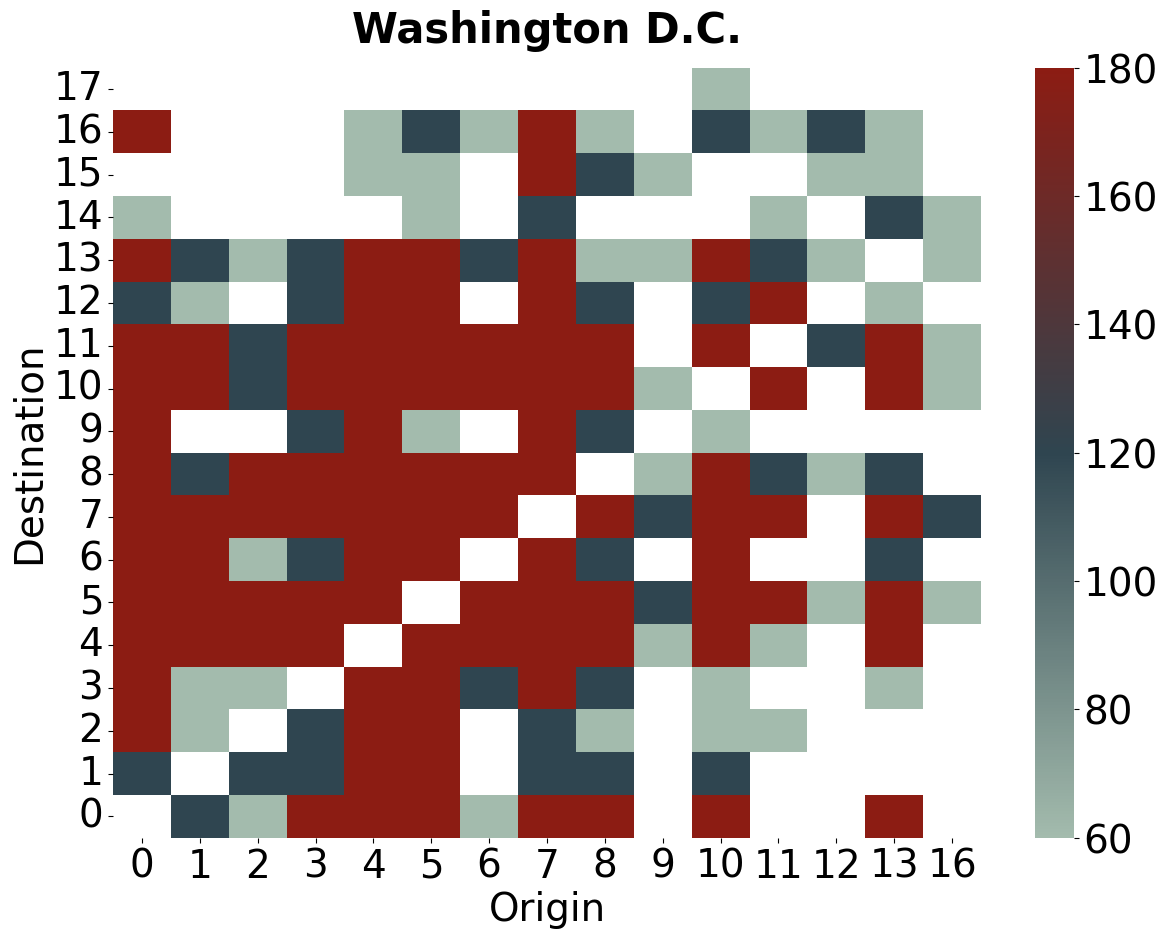

In [19]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#8C1C13", "#2F4550", "#A3BBAD"][::-1])
sns.heatmap(pivot_df.iloc[::-1], annot=False, fmt="d", cmap=cmap)
plt.title(f"{city_name}")
plt.xlabel(pivot_df.columns.name)
plt.ylabel(pivot_df.index.name)
plt.savefig(f"./figs/DistributionOfTrips_{city_name}")
plt.show()

In [20]:
# mean_demand_matrix = df.groupby("origin")["demand"].mean().values.reshape(1,pivot_df.shape[1])
# plt.figure(figsize=(10, 8))
# sns.heatmap(mean_demand_matrix.reshape(2,5), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Mean Demand'}, annot_kws={"size": 12})
# plt.title('Heatmap of Mean Demand in Each Grid')
# plt.xlabel('Longitude Grid')
# plt.ylabel('Latitude Grid')
# plt.show()

# Travel time analysis

C:\Users\Frederik\AppData\Local\Temp\ipykernel_8940\1961925715.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p, 'k', linewidth=2, color="#2F4550", label="Log-normal distribution")


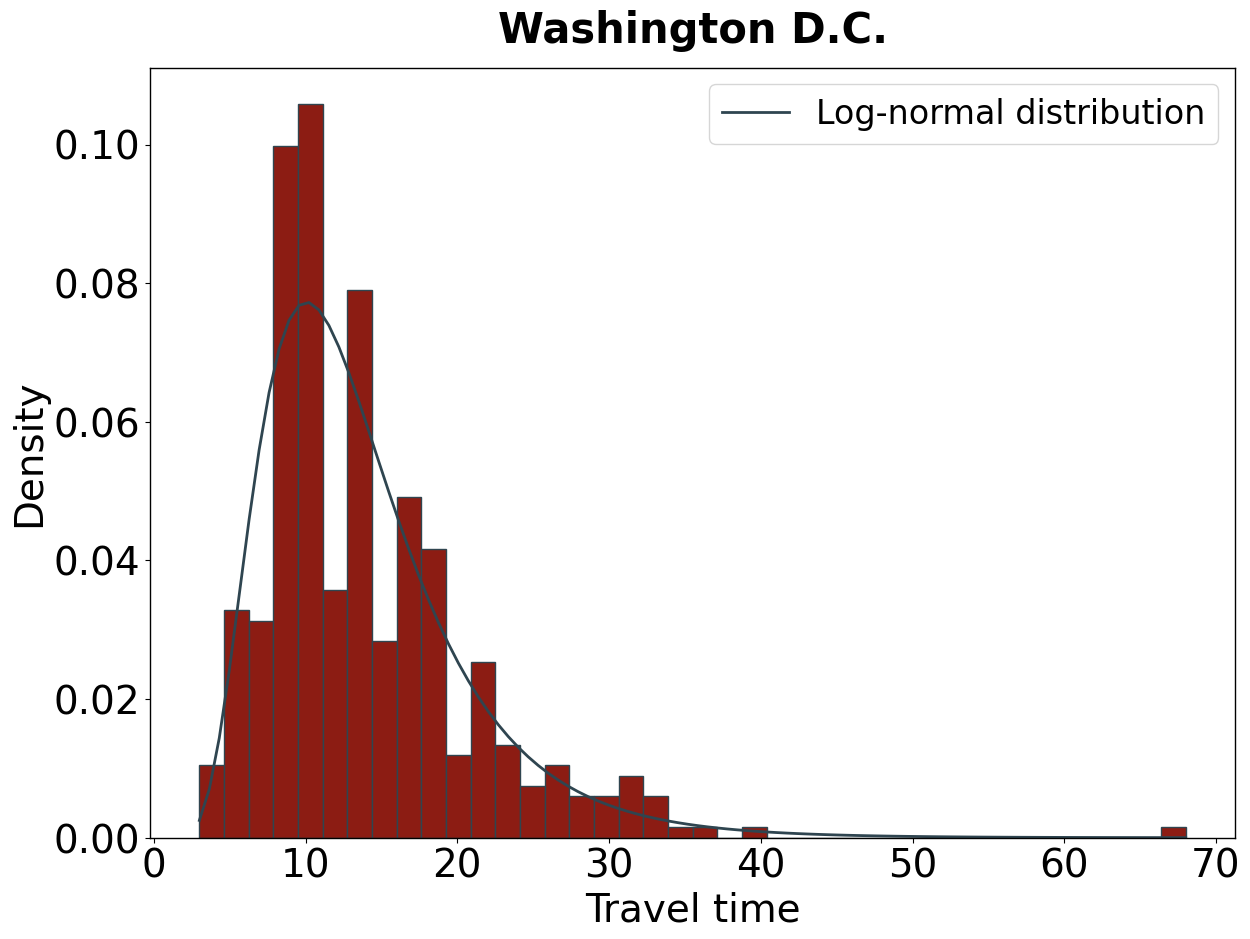

In [21]:
# Histogram plot
plt.hist(df["travel_time"], bins=40, density=True, alpha=1, edgecolor="#2F4550")

# Overlay a log-normal distribution
shape, loc, scale = stats.lognorm.fit(df["travel_time"], floc=0)
x = np.linspace(df["travel_time"].min(), df["travel_time"].max(), 100)
p = stats.lognorm.pdf(x, shape, loc, scale)
plt.plot(x, p, 'k', linewidth=2, color="#2F4550", label="Log-normal distribution")

plt.xlabel("Travel time")
plt.ylabel("Density")
plt.title(f"{city_name}")
plt.legend()
plt.savefig(f"./figs/TravelTimeDist_{city_name}")
plt.show()

# Price analysis

In [22]:
lognorm.fit(df["travel_time"])

(0.48667787037485366, 0.5792251834441202, 11.79673277962212)

C:\Users\Frederik\AppData\Local\Temp\ipykernel_8940\1057648776.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p, 'k', linewidth=2, color="#2F4550", label="Log-normal distribution")


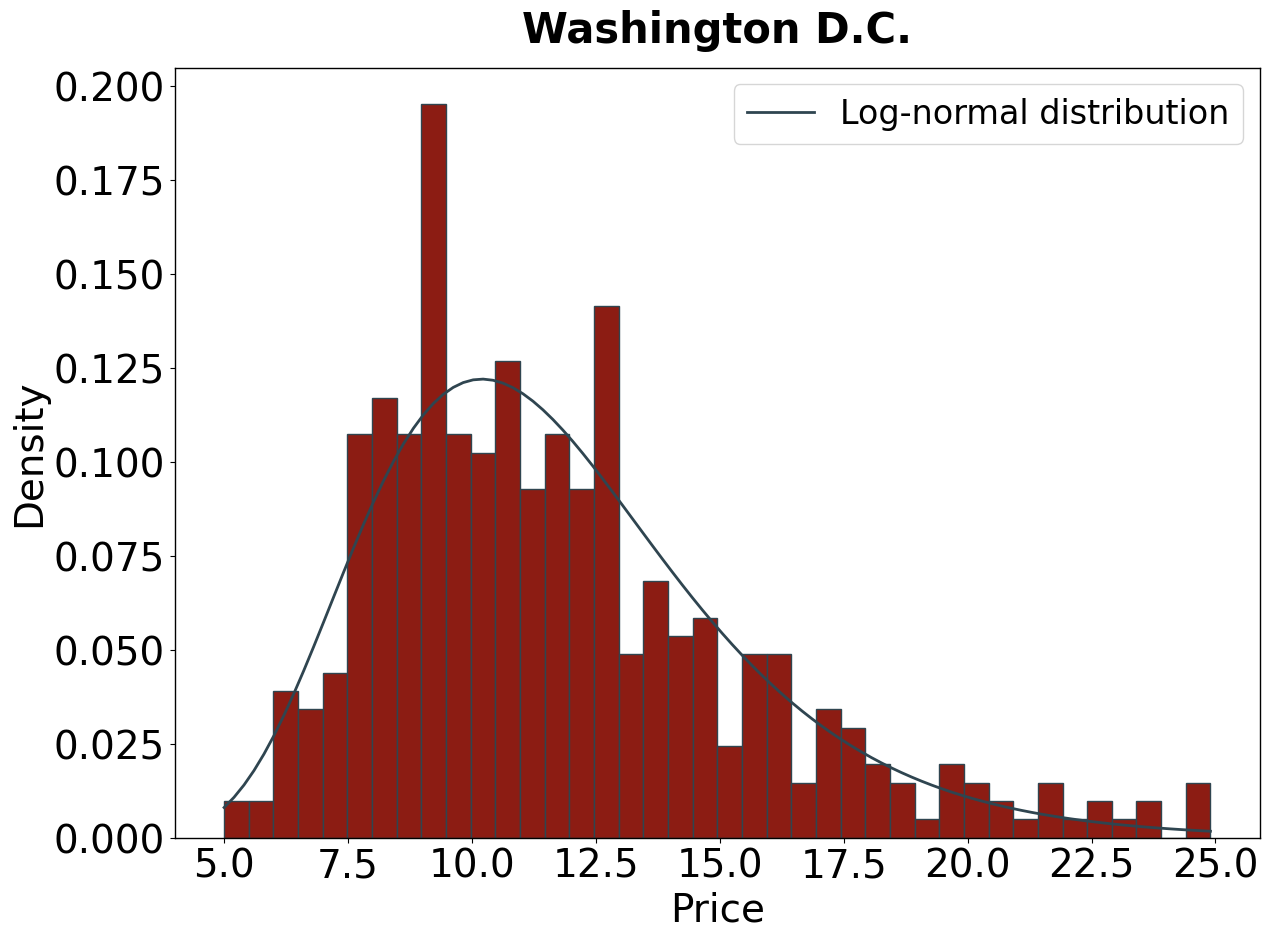

In [23]:
# Histogram plot
plt.hist(df["price"][df["price"]>0], bins=40, density=True, alpha=1, edgecolor="#2F4550")

# Overlay a log-normal distribution
shape, loc, scale = stats.lognorm.fit(df["price"][df["price"]>0], floc=0)
x = np.linspace(df["price"][df["price"]>0].min(), df["price"].max(), 100)
p = stats.lognorm.pdf(x, shape, loc, scale)
plt.plot(x, p, 'k', linewidth=2, color="#2F4550", label="Log-normal distribution")

plt.xlabel("Price")
plt.ylabel("Density")
plt.title(f"{city_name}")
plt.legend()
plt.savefig(f"./figs/DistOfPrice_{city_name}")
plt.show()

In [24]:
pred_df = df.copy()

In [25]:
pred_df["poly_travel_time"] = pred_df["travel_time"]**2
pred_df["poly_demand"] = pred_df["demand"]**2
pred_df["log_price"] = np.log(pred_df["price"])

c:\Users\Frederik\AppData\Local\pypoetry\Cache\virtualenvs\multi-agent-reinforcement-learning-EapXjS46-py3.10\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
sc = StandardScaler()

In [27]:
glm_model = smf.glm(formula="price ~ -1 + travel_time", data=pred_df, family=sm.families.Gaussian())
fitted_glm = glm_model.fit()

In [28]:
fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                24780
Model:                            GLM   Df Residuals:                    24779
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                          8.4446
Method:                          IRLS   Log-Likelihood:                -61595.
Date:                Mon, 22 Jan 2024   Deviance:                   2.0925e+05
Time:                        14:31:31   Pearson chi2:                 2.09e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5203
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
travel_time     0.7711      0.001    649.186      0.000       0.769       0.773
===============================================================================
"""

<Axes: xlabel='price', ylabel='Density'>

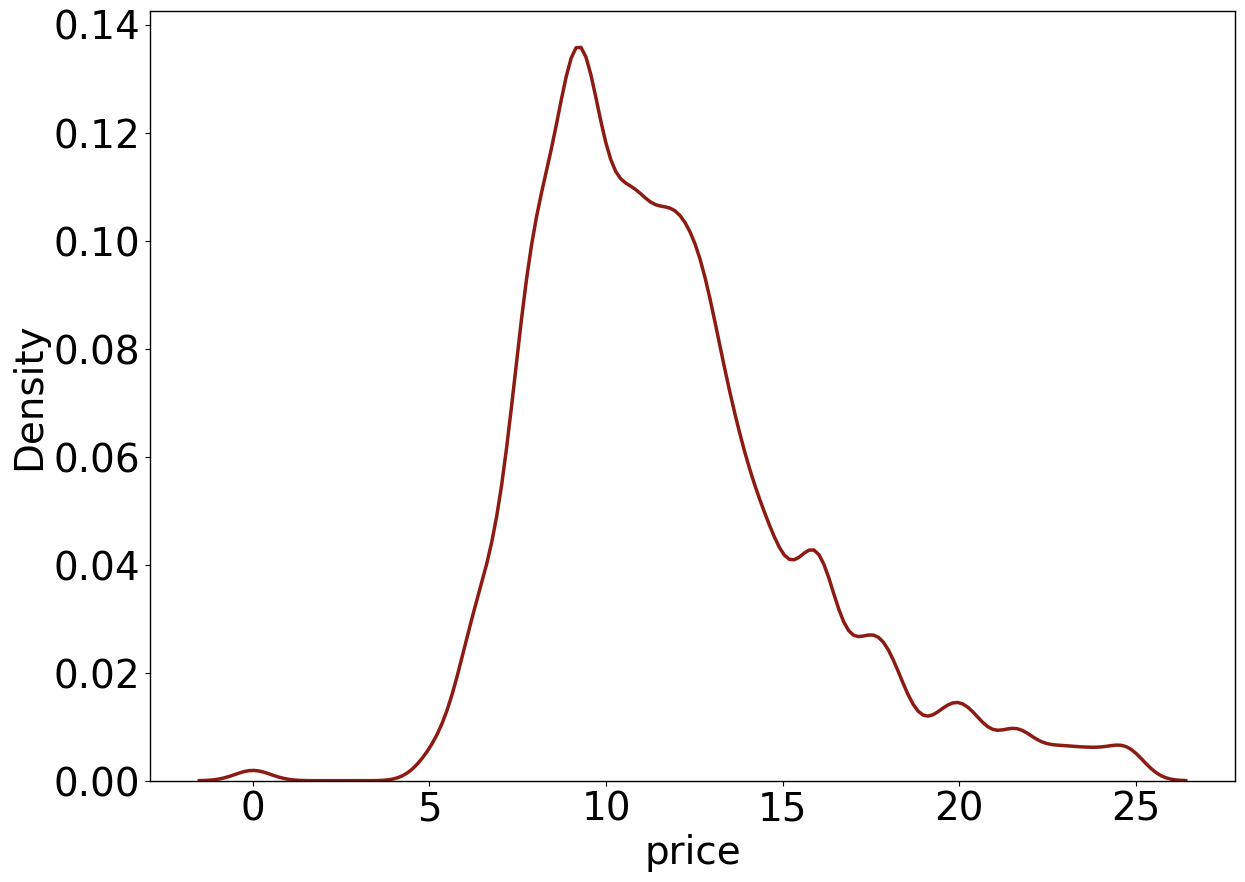

In [29]:
sns.kdeplot(df["price"])

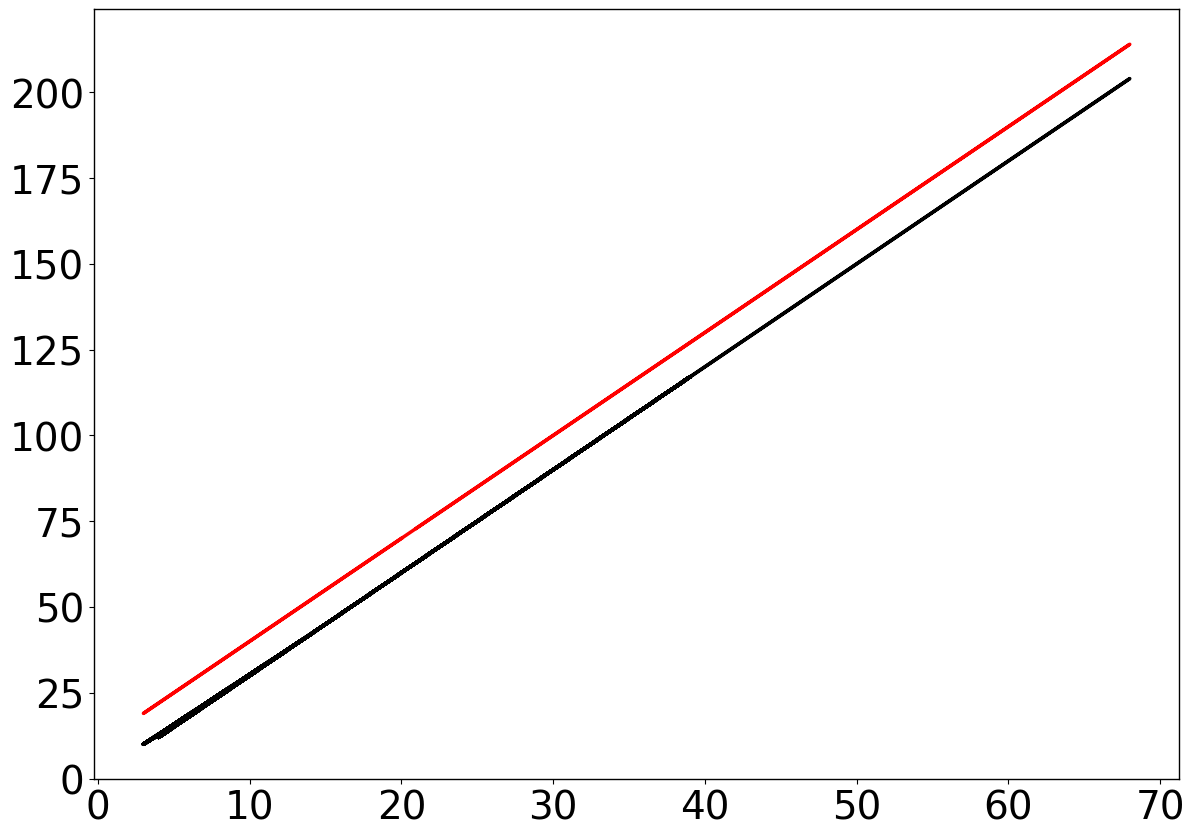

In [30]:
trans_price = df["travel_time"].values * 3
trans_price[trans_price < 10] = 10
plt.figure()
plt.plot(df["travel_time"], trans_price, color="black", label="RL")
plt.plot(df["travel_time"], 10 + df["travel_time"]*3, color="red", label="RL")
plt.show()


In [31]:
from statsmodels.stats.outliers_influence import summary_table

In [32]:
fitted_values = fitted_glm.get_prediction().summary_frame(alpha=0.05)
fitted_values = fitted_values.sort_values("mean")

In [33]:
df = df.merge(fitted_values, left_index=True, right_index=True)

In [34]:
fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                24780
Model:                            GLM   Df Residuals:                    24779
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                          8.4446
Method:                          IRLS   Log-Likelihood:                -61595.
Date:                Mon, 22 Jan 2024   Deviance:                   2.0925e+05
Time:                        14:31:33   Pearson chi2:                 2.09e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5203
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
travel_time     0.7711      0.001    649.186      0.000       0.769       0.773
===============================================================================
"""

In [35]:
10/1.5

6.666666666666667

In [36]:
df.loc[df["new_mean"] == 10, "travel_time"]

KeyError: 'new_mean'

In [ ]:
new_fitted = fitted_values["mean"].copy()
df["new_mean"] = df["mean"].copy()
df.loc[df["new_mean"] < 10, "new_mean"] = 10

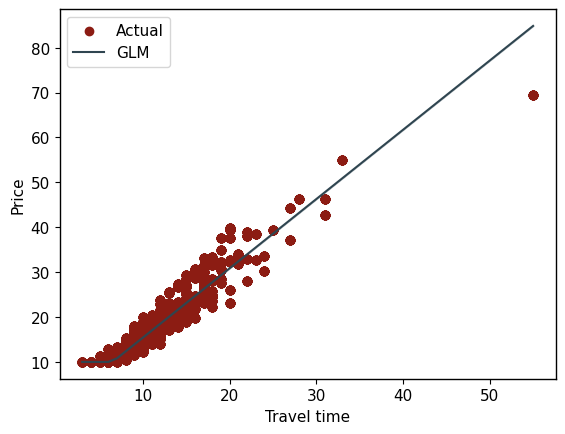

In [ ]:
plt.scatter(df["travel_time"], df["price"], label="Actual")
sns.lineplot(x=df["travel_time"], y=np.maximum(df["mean"], 10), color="#2F4550", label="GLM")
# plt.plot(df.loc[df["new_mean"] == 10, "travel_time"], df.loc[df["new_mean"] == 10, "new_mean"], color="#2F4550", label="GLM")
#plt.plot(df["travel_time"], df["travel_time"]*3, color="black", label="RL")
#plt.plot(df["travel_time"], df["travel_time"]*2, color="magenta", label="RL2")
plt.xlabel("Travel time")
plt.ylabel("Price")
plt.legend()
plt.savefig("./figs/reg_with_base.png")
plt.show()

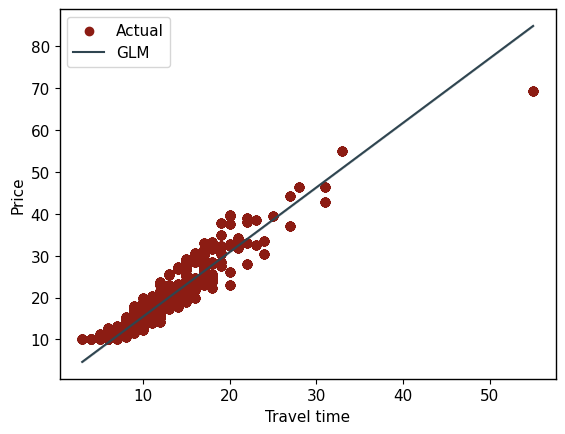

In [ ]:
plt.scatter(df["travel_time"], df["price"], label="Actual")
sns.lineplot(x=df["travel_time"], y=df["mean"], color="#2F4550", label="GLM")
#plt.plot(df["travel_time"], df["travel_time"]*3, color="black", label="RL")
#plt.plot(df["travel_time"], df["travel_time"]*2, color="magenta", label="RL2")
plt.xlabel("Travel time")
plt.ylabel("Price")
plt.legend()
plt.savefig("./figs/reg_without_base.png")
plt.show()

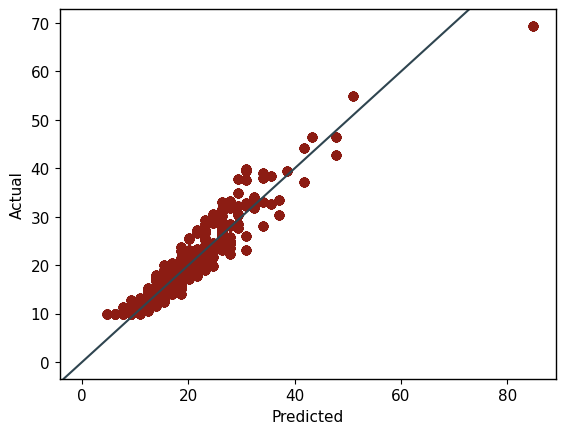

In [ ]:
plt.scatter(fitted_glm.predict(), pred_df["price"])
plt.axline((0,0), slope=1, color="#2F4550")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

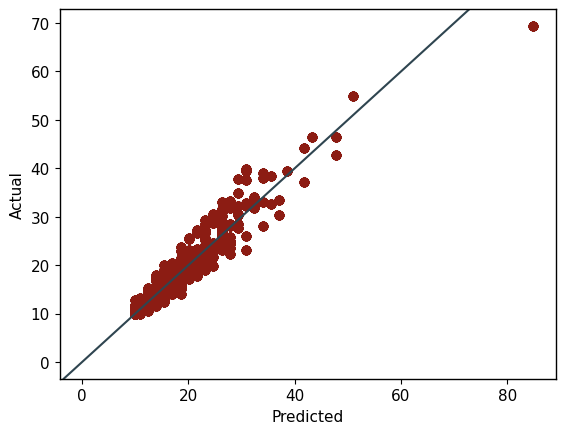

In [ ]:
plt.scatter(np.maximum(df["mean"],10), df["price"])
plt.axline((0,0), slope=1, color="#2F4550")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

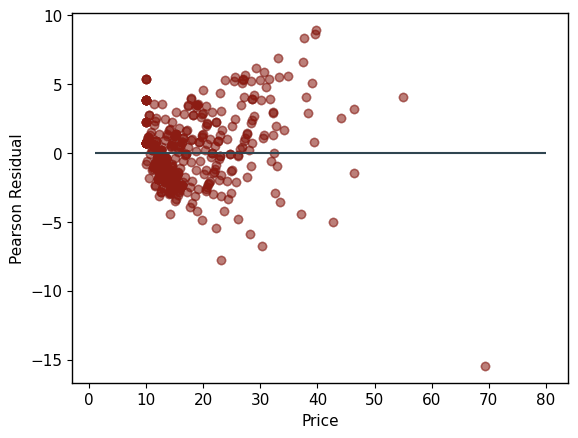

In [ ]:
plt.scatter(pred_df["price"], fitted_glm.resid_pearson, alpha=0.05)
plt.hlines(y=0, xmin=1, xmax=80, color="#2F4550")
plt.xlabel("Price")
plt.ylabel("Pearson Residual")
plt.savefig("./figs/res_without_base.png")
plt.show()

In [ ]:
# sns.scatterplot(x=pred_df["price"], y=fitted_glm.resid_pearson)
plt.scatter(pred_df["price"], df["price"] - np.maximum(df["mean"],10), alpha=0.05)
plt.hlines(y=0, xmin=1, xmax=80, color="#2F4550")
plt.xlabel("Price")
plt.ylabel("Pearson Residual")
plt.savefig("./figs/res_with_base.png")
plt.show()

# Predicting demand

In [ ]:
def model_2(vars, travel_time):
    alpha, beta = vars
    demand_hat = np.exp(alpha + beta * travel_time)
    return demand_hat

In [ ]:
def mse_model2(vars, price, travel_time):
    price_hat = model_2(vars, travel_time)
    return np.mean((price-price_hat)**2)

In [ ]:
x0 = (0,0)
res = minimize(mse_model2, x0, args=(df.price, df.travel_time), tol=1e-3, method="Powell")

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 20.92744780137508
       x: [ 2.447e+00  3.932e-02]
     nit: 4
   direc: [[ 1.000e+00  0.000e+00]
           [-2.373e-01  1.697e-02]]
    nfev: 98

In [ ]:
res.x

array([2.44746718, 0.03932451])

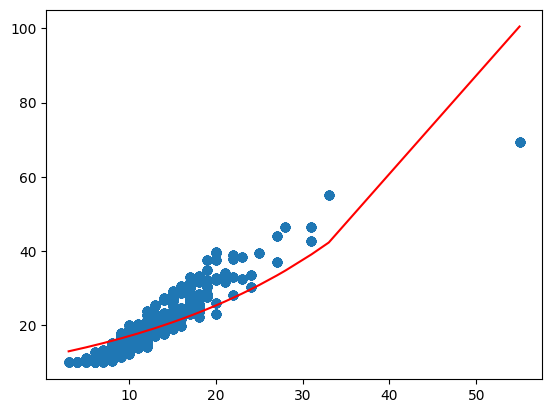

In [ ]:
plt.plot(df.travel_time.sort_values(ascending=False).values, model_2(res.x, df.travel_time.sort_values(ascending=False).values), color="red")
plt.scatter(df.travel_time.sort_values(ascending=False).values,df.sort_values("travel_time", ascending=False).price.values)
plt.show()

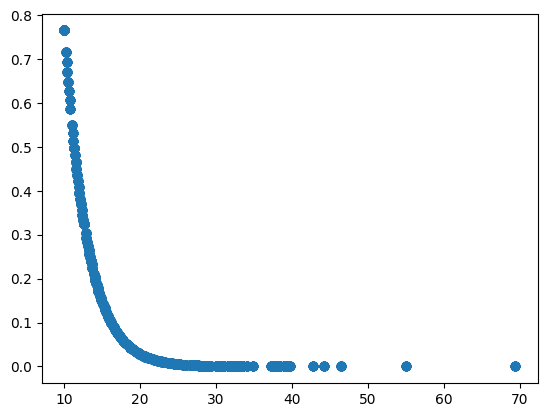

In [ ]:
plt.scatter(df["price"], np.exp(res.x[0] + res.x[1] * df["price"]))

In [ ]:
plt.plot(df.price.sort_values(ascending=False).values, model_2(res.x, df.demand.sort_values(ascending=False).values), color="red")
plt.scatter(df.price.sort_values(ascending=False).values,df.sort_values("price", ascending=False).demand.values)